In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read ground truth data
data = []

ground_truth_file_path = '../results/ground_truth.csv'

df_gt = pd.read_csv(ground_truth_file_path,index_col=0)
df_gt.head()

,A,B,C,D,E,F,G,H,I,J
A,--,A,C,--,--,F,G,--,--,J
B,A,--,--,D,B,F,G,B,B,--
C,C,--,--,C,C,C,G,C,C,--
D,--,D,C,--,--,F,G,D,--,J
E,--,B,C,--,--,E,G,--,--,J


In [6]:
# read real data from test run
data = []

# pattern = r'Users: (?P<current_user>.)(?P<interrupting_user>.). Gazebo: (?P<gazebo>\S+). Negotiation rounds: (?P<rounds>\d+). Preparation time: (?P<prep_time>\d+\.\d+) seconds. Negotiation time: (?P<time>\d+\.\d+) seconds. (?P<result>\S+)'
pattern = r'Users: (?P<current_user>.)(?P<interrupting_user>.). Gazebo: (?P<gazebo>\S+). Negotiation rounds: (?P<rounds>\d+). Preparation time: (?P<prep_time>\d+\.\d+) seconds. Negotiation time: (?P<time>\d+\.\d+) seconds. Result: (?P<result>\S+)'

log_file_path = '../results/task_progress.log'

# for log_file_path in sim_files:
with open(log_file_path, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            current_user = match.group("current_user")
            interrupting_user = match.group("interrupting_user")
            gazebo = bool(match.group("gazebo")) 
            rounds = int(match.group("rounds")) // 2 + (int(match.group("rounds")) % 2 > 0)
            time = float(match.group("time"))
            prep_time = float(match.group("prep_time"))
            result = match.group("result").lower()

            # if not gazebo:
            data.append({"current_user": current_user, "interrupting_user": interrupting_user, "rounds": rounds, "preparation_time": prep_time, "negotiation_time": time, "result": result})
        else:
            print("Diverging result: ")
            print(line)
df_rd = pd.DataFrame(data)
df_rd.head()

,current_user,interrupting_user,rounds,preparation_time,negotiation_time,result
0,A,B,2,1.023,0.031,current
1,A,C,3,1.005,0.023,interrupting
2,A,D,4,1.004,0.022,no-agreement
3,A,E,4,1.005,0.022,no-agreement
4,A,F,3,1.005,0.022,interrupting


In [7]:
# validation: check whether negotiation had expected outcome!
expected_outcome, differing_outcome = [],[]
for index, row in df_rd.iterrows():
    expected = df_gt.at[row["current_user"],row["interrupting_user"]]
    if (row["result"] == "current" and expected == row["current_user"]) or (row["result"] == "interrupting" and expected == row["interrupting_user"]) or (row["result"] == "no-agreement" and expected == "--"):
        expected_outcome.append(expected)
    else:
        print(f"Differing outcome! current user: {row["current_user"]}, interrupting user: {row["interrupting_user"]}")
        differing_outcome.append((row["result"],expected))

print("Negotiations with expected outcome: ", len(expected_outcome))
print("Negotiations with differing outcome: ", len(differing_outcome))
print("Percentage of negotiation with expected outcome: ", len(expected_outcome)/(len(expected_outcome)+len(differing_outcome))*100, "%")

Differing outcome! current user: B, interrupting user: A
Differing outcome! current user: C, interrupting user: G
Differing outcome! current user: D, interrupting user: J
Differing outcome! current user: F, interrupting user: E
Differing outcome! current user: H, interrupting user: B
Differing outcome! current user: H, interrupting user: D
Differing outcome! current user: H, interrupting user: J
Negotiations with expected outcome:  83
Negotiations with differing outcome:  7
Percentage of negotiation with expected outcome:  92.22222222222223 %


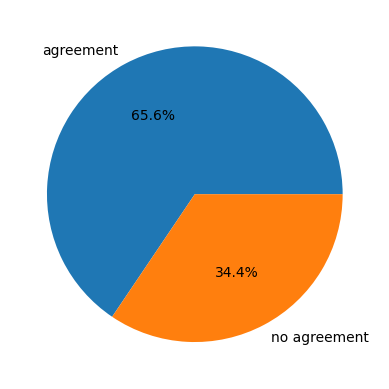

In [8]:
# analyze percentage of agreement vs non-agreement
no_agreement = df_rd.loc[df_rd["result"] == "no-agreement"]
current = df_rd.loc[df_rd["result"] == "current"]
interrupting = df_rd.loc[df_rd["result"] == "interrupting"]

plt.pie([(len(current) + len(interrupting))/90, len(no_agreement)/90], labels = ["agreement", "no agreement"], autopct='%1.1f%%')
# plt.legend()
plt.show()

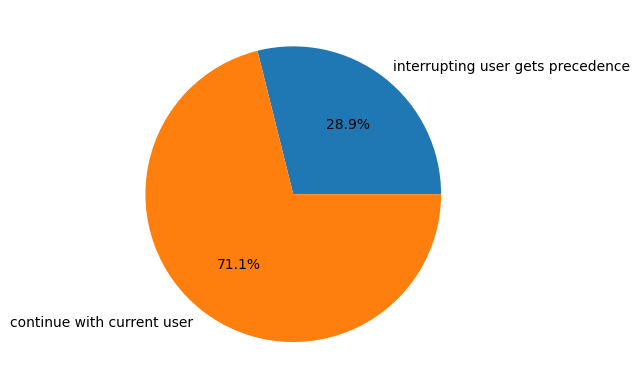

In [9]:
# analyze percentage of agreement vs non-agreement
no_agreement = df_rd.loc[df_rd["result"] == "no-agreement"]
current = df_rd.loc[df_rd["result"] == "current"]
interrupting = df_rd.loc[df_rd["result"] == "interrupting"]

print()
plt.pie([len(interrupting)/90,(len(current) + len(no_agreement))/90], labels = ["interrupting user gets precedence", "continue with current user"], autopct='%1.1f%%')
# plt.legend()
plt.show()

In [16]:
users_list = df_rd["current_user"].unique()
users_interrupting_list = df_rd["interrupting_user"].unique()

pairs = []

for u1 in users_list:
    if u1 not in users_interrupting_list:
        print(f"user {u1} is not in interrupting users list!!")
    for u2 in users_list:
        if u1 == u2 : continue
        assignment1 = df_rd.loc[(df_rd["current_user"]==u1) & (df_rd["interrupting_user"]==u2)]["result"].item()
        assignment2 = df_rd.loc[(df_rd["current_user"]==u2) & (df_rd["interrupting_user"]==u1)]["result"].item()
        if assignment1 == "no-agreement" and assignment2 == "no-agreement" or assignment1 == "current" and assignment2 == "interrupting" or assignment1 == "interrupting" and assignment2 == "current":
            continue
        if not (u1,u2) in pairs and  not (u2,u1) in pairs: 
            print("results with switched roles are not consistent!")
            print(f"users: {u1},{u2}")
            print(f"assignment1: {assignment1}, assignment2: {assignment2}")
            pairs.append((u1,u2))


results with switched roles are not consistent!
users: A,B
assignment1: current, assignment2: no-agreement
results with switched roles are not consistent!
users: B,H
assignment1: current, assignment2: no-agreement
results with switched roles are not consistent!
users: C,G
assignment1: no-agreement, assignment2: current
results with switched roles are not consistent!
users: D,H
assignment1: current, assignment2: no-agreement
results with switched roles are not consistent!
users: D,J
assignment1: no-agreement, assignment2: current
results with switched roles are not consistent!
users: E,F
assignment1: current, assignment2: no-agreement
results with switched roles are not consistent!
users: H,J
assignment1: no-agreement, assignment2: current
